# First, mount the drive to get access to dataset

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset from drive

In [2]:
import os
import pandas as pd

# Specify the path to dataset and the file name
DATASET_DIR = os.path.join(os.getcwd(), r'drive/MyDrive/NLP Final Project/datasets/sentiment140_kaggle')
FILE = os.path.join(DATASET_DIR, r'Sentiment140.annotated.resampled.100000.csv')

# Open the csv file as a pandas DataFrame with specified columns
tweets_df = pd.read_csv(FILE, sep=',', encoding='utf-8')
tweets_df

,target,tweet,label
0,0,@mimsay We'll miss you. Congrats lil lady.,negative
1,0,Feeling sorry for myself today cos of my drunk...,negative
2,0,My computer won't let me online. On laptop n...,negative
3,0,New Post and lots of sulking http://tinyurl...,negative
4,0,@purplepleather AWW,negative
...,...,...,...
999995,4,@babygirlparis Ten bucks says I know where you...,joy
999996,4,is at the gym then off to cocoa beach for Sund...,joy
999997,4,@joek949 Morning you! Might go to the beach...,joy
999998,0,"maybe going to the beach after work, got 17kno...",joy


# Cleaning the raw tweets

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

> Remove the word 'not' from stopwords as it specifies a negative emotion

In [4]:
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

def clean(tweet):

    # Remove @usermentions (for a tweet)
    tweet = re.sub('@[^\s]+',' ',tweet)

    # Remove urls (for a tweet)
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',tweet)
    
    # Replace #word with word (for a tweet)
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # Remove all remaining punctuations
    tweet = re.sub(r'[^a-zA-Z]', ' ', tweet)

    # Convert tweet to lowercase
    tweet = tweet.lower()
    
    # Apply stemming to reduce sparse matrix dimensionality
    tweet = tweet.split()
    tweet = [PorterStemmer().stem(word) for word in tweet if not word in set(all_stopwords)]
    tweet = ' '.join(tweet)
    
    return tweet

> Apply to the `clean` function to DataFrame

In [5]:
%%time
tweets_df['cleaned_tweet'] = tweets_df['tweet'].apply(clean)

CPU times: user 4min 23s, sys: 500 ms, total: 4min 24s
Wall time: 4min 24s


In [6]:
tweets_df

,target,tweet,label,cleaned_tweet
0,0,@mimsay We'll miss you. Congrats lil lady.,negative,miss congrat lil ladi
1,0,Feeling sorry for myself today cos of my drunk...,negative,feel sorri today co drunken antic last night l...
2,0,My computer won't let me online. On laptop n...,negative,comput let onlin laptop not upload pic anyth cri
3,0,New Post and lots of sulking http://tinyurl...,negative,new post lot sulk
4,0,@purplepleather AWW,negative,aww
...,...,...,...,...
999995,4,@babygirlparis Ten bucks says I know where you...,joy,ten buck say know go think let know boulder st...
999996,4,is at the gym then off to cocoa beach for Sund...,joy,gym cocoa beach sunday funday
999997,4,@joek949 Morning you! Might go to the beach...,joy,morn might go beach think
999998,0,"maybe going to the beach after work, got 17kno...",joy,mayb go beach work got knot wind today hope no...


# Bag-of-Words model

> A typical native English speaker uses 20,000 words. So, we will set the `max_features` to 20,000.

In [9]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import Pipeline

bow_pipe = Pipeline([
    ('count_vect', CountVectorizer(max_features=20000)),
    ('maxabs_scaler', MaxAbsScaler()),
])


X = bow_pipe.fit_transform(tweets_df['cleaned_tweet'])
y = tweets_df.label.values

CPU times: user 9.28 s, sys: 192 ms, total: 9.47 s
Wall time: 9.5 s


In [10]:
X

<1000000x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 7182380 stored elements in Compressed Sparse Row format>

> Next, we split the dataset into train set and test set

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Naive Bayes Classifier

* *GaussianNB*

* *MultinomialNB*

> Since the dataset is a very large sparse matrix, we can't fit it into memory.

> So, we will create a custom class that implements `partial_fit` method by a given batch size.

In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB


class NB:

    def __init__(self, clf_type='gnb'):
        if clf_type == 'gnb':
            self.clf = GaussianNB()
        elif clf_type == 'mnb':
            self.clf = MultinomialNB()
        else:
            print("Wrong classifier !!! 'gnb' -> GaussianNB() | 'mnb' -> MulitinomialNB()")
            return

    # fits the classifier
    def slow_fit(self, X, y, classes, batch_size=10000):
        # X must be a sparse matrix
        current_index = 0
        n_samples = X.shape[0]
        n_batches = n_samples / batch_size

        print(f"{n_batches} batches created\n")

        now_batch = 1

        while current_index != n_samples:
            print(f"Batch {now_batch} : {current_index} - {current_index + batch_size} in training...")
            X_batch = X[current_index:current_index + batch_size].toarray()
            y_batch = y[current_index:current_index + batch_size]
            if current_index == 0:
                self.clf.partial_fit(X_batch, y_batch, classes=classes)
            else:
                self.clf.partial_fit(X_batch, y_batch)
            current_index += batch_size
            now_batch += 1

        print("\nFit completed !!!")
        print(self.clf)

    # returns a list of predictions
    def get_predictions(self, X, batch_size=1000):
        # X must be a sparse matrix
        current_index = 0
        n_samples = X.shape[0]
        n_batches = n_samples / batch_size

        print(f"{n_batches} batches created\n")

        now_batch = 1
        predictions = list()
        while current_index != n_samples:
            print(f"Batch {now_batch} : {current_index} - {current_index + batch_size} predictions...")
            X_batch = X[current_index:current_index + batch_size].toarray()
            pred_list = self.clf.predict(X_batch).tolist()
            predictions.extend(pred_list)
            current_index += batch_size
            now_batch += 1
            
        return predictions

### **GaussianNB**

In [13]:
%%time
nb = NB('gnb')

nb.slow_fit(X_train, y_train, classes=list(set(y)), batch_size=10000)

80.0 batches created

Batch 1 : 0 - 10000 in training...
Batch 2 : 10000 - 20000 in training...
Batch 3 : 20000 - 30000 in training...
Batch 4 : 30000 - 40000 in training...
Batch 5 : 40000 - 50000 in training...
Batch 6 : 50000 - 60000 in training...
Batch 7 : 60000 - 70000 in training...
Batch 8 : 70000 - 80000 in training...
Batch 9 : 80000 - 90000 in training...
Batch 10 : 90000 - 100000 in training...
Batch 11 : 100000 - 110000 in training...
Batch 12 : 110000 - 120000 in training...
Batch 13 : 120000 - 130000 in training...
Batch 14 : 130000 - 140000 in training...
Batch 15 : 140000 - 150000 in training...
Batch 16 : 150000 - 160000 in training...
Batch 17 : 160000 - 170000 in training...
Batch 18 : 170000 - 180000 in training...
Batch 19 : 180000 - 190000 in training...
Batch 20 : 190000 - 200000 in training...
Batch 21 : 200000 - 210000 in training...
Batch 22 : 210000 - 220000 in training...
Batch 23 : 220000 - 230000 in training...
Batch 24 : 230000 - 240000 in training...
Ba

> To get the predictions

In [14]:
%%time
y_pred = nb.get_predictions(X_test, batch_size=1000)

200.0 batches created

Batch 1 : 0 - 1000 predictions...
Batch 2 : 1000 - 2000 predictions...
Batch 3 : 2000 - 3000 predictions...
Batch 4 : 3000 - 4000 predictions...
Batch 5 : 4000 - 5000 predictions...
Batch 6 : 5000 - 6000 predictions...
Batch 7 : 6000 - 7000 predictions...
Batch 8 : 7000 - 8000 predictions...
Batch 9 : 8000 - 9000 predictions...
Batch 10 : 9000 - 10000 predictions...
Batch 11 : 10000 - 11000 predictions...
Batch 12 : 11000 - 12000 predictions...
Batch 13 : 12000 - 13000 predictions...
Batch 14 : 13000 - 14000 predictions...
Batch 15 : 14000 - 15000 predictions...
Batch 16 : 15000 - 16000 predictions...
Batch 17 : 16000 - 17000 predictions...
Batch 18 : 17000 - 18000 predictions...
Batch 19 : 18000 - 19000 predictions...
Batch 20 : 19000 - 20000 predictions...
Batch 21 : 20000 - 21000 predictions...
Batch 22 : 21000 - 22000 predictions...
Batch 23 : 22000 - 23000 predictions...
Batch 24 : 23000 - 24000 predictions...
Batch 25 : 24000 - 25000 predictions...
Batch 26

# Classification report

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Report:\n")
average = 'macro'
print(f"Accuracy score  : {accuracy_score(y_test, y_pred)}")
print(f"Precision score : {precision_score(y_test, y_pred, average=average)}")
print(f"Recall score    : {recall_score(y_test, y_pred, average=average)}")
print(f"F1 score        : {f1_score(y_test, y_pred, average=average)}")

Report:

Accuracy score  : 0.299205
Precision score : 0.3280269466305415
Recall score    : 0.2994259246776185
F1 score        : 0.22351391634907763


> We plot the confuaion matrix to understand visually

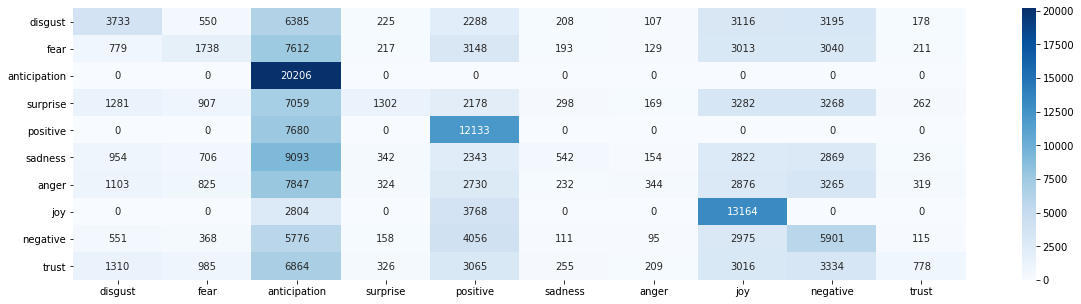

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20, 5))

sns.heatmap(cm, fmt="d", annot=True, cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))

### **MultinomialNB**

In [17]:
%%time
nb = NB('mnb')

nb.slow_fit(X_train, y_train, classes=list(set(y)), batch_size=10000)

80.0 batches created

Batch 1 : 0 - 10000 in training...
Batch 2 : 10000 - 20000 in training...
Batch 3 : 20000 - 30000 in training...
Batch 4 : 30000 - 40000 in training...
Batch 5 : 40000 - 50000 in training...
Batch 6 : 50000 - 60000 in training...
Batch 7 : 60000 - 70000 in training...
Batch 8 : 70000 - 80000 in training...
Batch 9 : 80000 - 90000 in training...
Batch 10 : 90000 - 100000 in training...
Batch 11 : 100000 - 110000 in training...
Batch 12 : 110000 - 120000 in training...
Batch 13 : 120000 - 130000 in training...
Batch 14 : 130000 - 140000 in training...
Batch 15 : 140000 - 150000 in training...
Batch 16 : 150000 - 160000 in training...
Batch 17 : 160000 - 170000 in training...
Batch 18 : 170000 - 180000 in training...
Batch 19 : 180000 - 190000 in training...
Batch 20 : 190000 - 200000 in training...
Batch 21 : 200000 - 210000 in training...
Batch 22 : 210000 - 220000 in training...
Batch 23 : 220000 - 230000 in training...
Batch 24 : 230000 - 240000 in training...
Ba

> To get the predictions

In [18]:
%%time
y_pred = nb.get_predictions(X_test, batch_size=1000)

200.0 batches created

Batch 1 : 0 - 1000 predictions...
Batch 2 : 1000 - 2000 predictions...
Batch 3 : 2000 - 3000 predictions...
Batch 4 : 3000 - 4000 predictions...
Batch 5 : 4000 - 5000 predictions...
Batch 6 : 5000 - 6000 predictions...
Batch 7 : 6000 - 7000 predictions...
Batch 8 : 7000 - 8000 predictions...
Batch 9 : 8000 - 9000 predictions...
Batch 10 : 9000 - 10000 predictions...
Batch 11 : 10000 - 11000 predictions...
Batch 12 : 11000 - 12000 predictions...
Batch 13 : 12000 - 13000 predictions...
Batch 14 : 13000 - 14000 predictions...
Batch 15 : 14000 - 15000 predictions...
Batch 16 : 15000 - 16000 predictions...
Batch 17 : 16000 - 17000 predictions...
Batch 18 : 17000 - 18000 predictions...
Batch 19 : 18000 - 19000 predictions...
Batch 20 : 19000 - 20000 predictions...
Batch 21 : 20000 - 21000 predictions...
Batch 22 : 21000 - 22000 predictions...
Batch 23 : 22000 - 23000 predictions...
Batch 24 : 23000 - 24000 predictions...
Batch 25 : 24000 - 25000 predictions...
Batch 26

> Now, we report the classification scores on 'macro' average

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Report:\n")
average = 'macro'
print(f"Accuracy score  : {accuracy_score(y_test, y_pred)}")
print(f"Precision score : {precision_score(y_test, y_pred, average=average)}")
print(f"Recall score    : {recall_score(y_test, y_pred, average=average)}")
print(f"F1 score        : {f1_score(y_test, y_pred, average=average)}")

Report:

Accuracy score  : 0.689835
Precision score : 0.6755804397935175
Recall score    : 0.6900935799097384
F1 score        : 0.6770295961793757


> We plot the confuaion matrix to understand visually

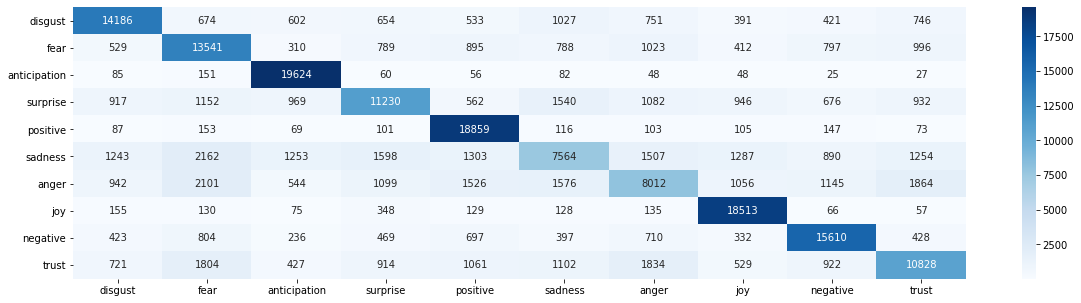

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20, 5))

sns.heatmap(cm, fmt="d", annot=True, cmap='Blues', xticklabels=list(set(y)), yticklabels=list(set(y)))